# "Fourth" attempt at building a RISE explainer for embedded spaces

After going back to the previous notebooks, we noticed that we had left out the power multiplication factor 20 in the exponential that initially gave us our most stable results (also leading to all the other attempts, because they seemed reasonable). After trying it out again, this seemed to really improve results.

In this notebook we revisit this factor. We add it in the explain method and see what the results are on different images and we vary the value of the factor to find a optimum.

In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from tensorflow.keras import backend as K
from skimage.transform import resize
from requests import get
import os
from urllib.parse import urlparse
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import random
import tensorflow as tf
from keras import backend as K


class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)


def load_img(path, target_size):
    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x





def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]


def download(url):
    filename = os.path.basename(urlparse(url).path)
    os.system(f"wget {url}")
    return filename


def plot_explainer(image, saliency, ax=None, vmin=None, vmax=None, title="Explanation",
                   do_cbar=True, add_value_limits_to_title=False, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = ax.get_figure()
    if add_value_limits_to_title:
        if vmin is None:
            vmin_title = saliency.min()
        else:
            vmin_title = vmin
        if vmax is None:
            vmax_title = saliency.max()
        else:
            vmax_title = vmax
        title = f"{title} vmin = {vmin_title:.2f}, vmax = {vmax_title:.2f}"
    ax.set_title(title)
    ax.axis('off')
    ax.imshow(image)
    im = ax.imshow(saliency, cmap='jet', alpha=0.5, vmin=vmin, vmax=vmax)
    if do_cbar:
      plt.colorbar(im, ax=ax)      
    return fig


# from https://stackoverflow.com/a/52897216/1199693
def set_all_the_seeds(seed_value=0):
    os.environ['PYTHONHASHSEED']=str(seed_value)

    random.seed(seed_value)

    np.random.seed(seed_value)

    tf.random.set_seed(seed_value)

    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [2]:
# import importlib
# importlib.reload(embeddings)

In [3]:
model = Model()


C:\Users\ChristiaanMeijer\anaconda3\envs\dianna-x\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [4]:
# _urls = ['https://www.publicdomainpictures.net/pictures/50000/velka/liten-fluga.jpg',
#          'https://publicdomainpictures.net/pictures/140000/velka/bee-painting.jpg']
# _filenames = [download(url) for url in _urls]

_filenames = ['liten-fluga.jpg', 'bee-painting.jpg']

img_fly, x_fly = load_img(_filenames[0], model.input_size)
img_bee, x_bee = load_img(_filenames[1], model.input_size)
print(x_bee.shape)

(1, 224, 224, 3)


Explaining: 100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


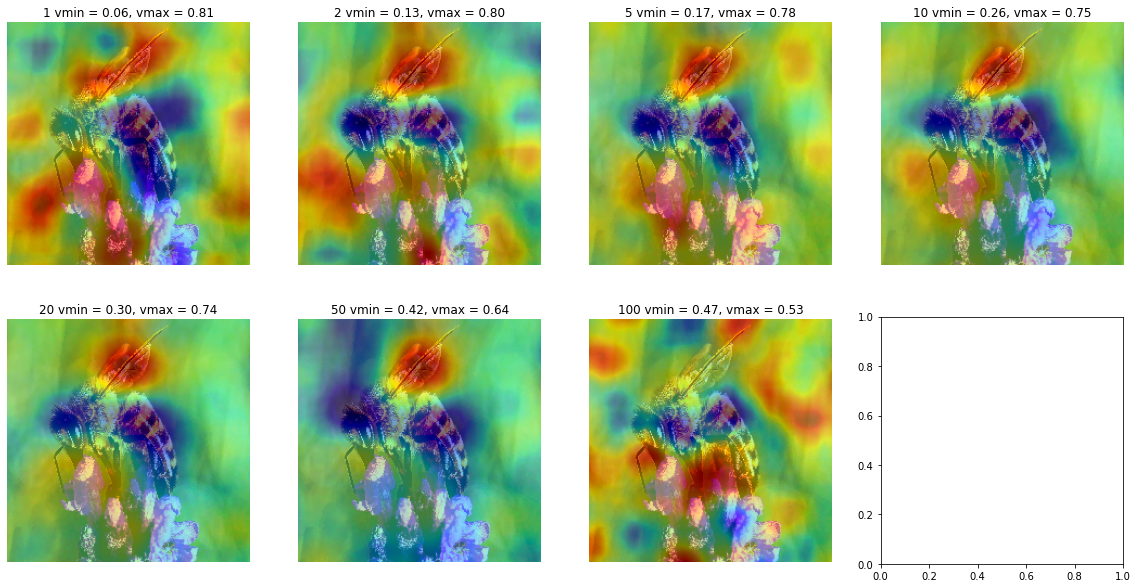

In [5]:

import importlib
import dianna
importlib.reload(dianna)

percentages = [1, 2, 5, 10, 20, 50, 100]
fig, ax = plt.subplots(2, len(percentages)//2 + 1, figsize=(20,10))
embedded_reference = model.run_on_batch(x_fly)
for ix, percentage in enumerate(percentages):
  _sal = dianna.explain_image_distance(model.run_on_batch, x_bee[0], 
  embedded_reference, p_keep_lowest_distances=percentage/100, n_masks=1000, axis_labels={2: 'channels'})
  # explain2(model, x_bee, x_fly, _masks, preds=_masked_predictions, keep_lowest_distance_masks_fraction=percentage/100)
  plot_explainer(img_bee, _sal[0], ax=ax.flatten()[ix], title=percentage, add_value_limits_to_title=True, do_cbar=False)
plt.show()